In [69]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from skimage.io import imread
import matplotlib.pyplot as plt
import pigleg_cv
import shutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
!pwd

/webapps/piglegsurgery/piglegcv


In [38]:
import torch
torch.cuda.is_available()

True

In [39]:
!nvidia-smi

Wed Dec 13 16:12:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:42:00.0 Off |                  N/A |
|  0%   39C    P8     9W / 250W |   2592MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [40]:
torch.__version__

'1.12.0a0+8a1a93a'

In [41]:
Path("~/.cache/torch/hub/checkpoints/").expanduser().exists()

True

In [42]:
!ls ~/.cache/torch/hub/checkpoints/

yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth


In [12]:
# pip install mmcv-full

# Run whole video processing

In [72]:
outputdir = "./del_test_video_output/"

In [103]:
patch = "*/Anasto*.mp4"
# patch = "*/2023_10_11_B-Grübbel_Mareike_Fortlaufende_Transkutannaht.mov"
patch = "*/Einzel.MOV"
patch = "*/*test_4.mp4"
patch = "*/*micro_01*.mp4"
patch = "*/2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"
patch = "Katharina_Einzelknopfnaht"
is_microsurgery = False
test_first_seconds=False
n_stitches = 3

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
img_pths[0]

PosixPath('../piglegsurgeryweb/media/upload/20220707-190320_Good-03_11_2021_B_Holzmu_ller_Katharina_Einzelknopfnaht_7ba22f6773dc133ce7a06321ee9f507b9cb0f653/Good-03_11_2021_B_Holzmu_ller_Katharina_Einzelknopfnaht.mp4')

In [110]:
# this is to test it on processed video
outputdir = Path("del_test_video_output_copy")
shutil.rmtree(outputdir, ignore_errors=True)
patch = "2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4"
patch = "Katharina_Einzelknopfnaht"
img_pths = list(Path("../piglegsurgeryweb/media/").glob(f"**/*{patch}*.zip"))
print(img_pths)
shutil.copytree(str(img_pths[0].parent), str(outputdir))

outputdir = list(outputdir.glob("*/*"))[0].parent

img_pths = list(Path("../piglegsurgeryweb/media/upload/").glob(f"*/*{patch}*"))
print(img_pths[0])
# img_pths[0].parent
# outputdir = Path("/webapps/piglegsurgery/piglegsurgeryweb/media/SA_20231011-191116_doqinglbsdnj").glob("**/*")
# list(outputdir)
outputdir

[PosixPath('../piglegsurgeryweb/media/SA_20220707-190320_tl4ev95290pp/SA_20220707-190320Good-03_11_2021_B_Holzmu_ller_Katharina_Einzelknopfnaht.mp4.zip')]
../piglegsurgeryweb/media/upload/20220707-190320_Good-03_11_2021_B_Holzmu_ller_Katharina_Einzelknopfnaht_7ba22f6773dc133ce7a06321ee9f507b9cb0f653/Good-03_11_2021_B_Holzmu_ller_Katharina_Einzelknopfnaht.mp4


PosixPath('del_test_video_output_copy/SA_20220707-190320')

# Do it per partes

2023-12-14 14:57:38.040 | DEBUG    | run_perpendicular:get_frame_to_process:162 - 6177
2023-12-14 14:57:38.122 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:229 - device=cuda
/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2023-12-14 14:57:38.353 | DEBUG    | run_qr:get_bboxes:37 - [[     1328.5      287.58      1485.1      451.83     0.97808]
 [     108.18      43.064      1538.2      1173.1     0.15091]
 [     240.01      545.99      1587.6      1175.6    0.097176]]
2023-12-14 14:57:38.518 | DEBUG    | run_qr:bbox_info_extraction_from_frame:80 - qr code text = 'QR scale pigleg'
2023-12-14 14:57:38.520 | DEBUG    | run_qr:bbox_info_extraction_from_frame:148 - {'bbox_scene_area': [199.8336181640625,
                     51.34346008300781,
                     1767.58

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2023-12-14 14:57:39,040 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - number of detected incisions = 0
2023-12-14 14:57:39.042 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:240 - {'bbox_scene_area': [199.8336181640625,
                     51.34346008300781,
                     1767.5875244140625,
                     1151.5894775390625,
                     0.3984905481338501],
 'box': [[1329, 345], [1384, 445], [1483, 392], [1428, 294]],
 'incision_bboxes': [],
 'incision_bboxes_old': [],
 'is_detected': True,
 'pix_size': 0.0002365782953426947,
 'pix_size_method': 'QR',
 'pix_size_single_frame_detector_m': 0.00023456986295201842,
 'qr_bboxes_SFD': [[1328.474365234375,
                    287.58404541015625,
                    1485.0692138671875,
                    451.825927734375,
                    0.9780839085578918]],
 'qr_scissors_frame_detected': False,
 'qr_scissors_frames': [],
 'qr_size': 0.027,
 'size_by_scene': 0.00015625,
 't

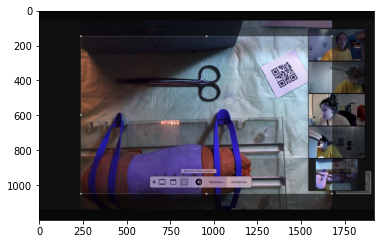

In [111]:

# pigleg_cv.do_computer_vision(img_pths[0], outputdir , meta=None)
dcv = pigleg_cv.DoComputerVision(
    img_pths[0], outputdir, test_first_seconds=test_first_seconds, is_microsurgery=is_microsurgery,
    n_stitches=n_stitches
)

# qr_data = dcv.get_parameters_for_crop_rotate_rescale()

dcv._make_sure_media_is_cropped()
plt.imshow(dcv.frame)
# dcv.run_image_processing()
# dcv._run_tracking()
# dcv._make_report()
# dcv._save_results()

In [107]:
dcv.frame

array(None, dtype=object)

In [ ]:
dcv._run_tracking()

In [ ]:
dcv._make_report()
dcv._save_results()

### Check the parameters for rotate and crop

2023-12-14 18:27:24.596 | DEBUG    | run_perpendicular:get_frame_to_process:162 - 6177
2023-12-14 18:27:24.670 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:229 - device=cuda
/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
2023-12-14 18:27:24.923 | DEBUG    | run_qr:get_bboxes:37 - [[     1328.5      287.58      1485.1      451.83     0.97808]
 [     108.18      43.064      1538.2      1173.1     0.15091]
 [     240.01      545.99      1587.6      1175.6    0.097176]]
2023-12-14 18:27:25.089 | DEBUG    | run_qr:bbox_info_extraction_from_frame:80 - qr code text = 'QR scale pigleg'
2023-12-14 18:27:25.092 | DEBUG    | run_qr:bbox_info_extraction_from_frame:148 - {'bbox_scene_area': [199.8336181640625,
                     51.34346008300781,
                     1767.58

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2023-12-14 18:27:25,625 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - number of detected incisions = 0
2023-12-14 18:27:25.627 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:240 - {'bbox_scene_area': [199.8336181640625,
                     51.34346008300781,
                     1767.5875244140625,
                     1151.5894775390625,
                     0.3984905481338501],
 'box': [[1329, 345], [1384, 445], [1483, 392], [1428, 294]],
 'incision_bboxes': [],
 'incision_bboxes_old': [],
 'is_detected': True,
 'pix_size': 0.0002365782953426947,
 'pix_size_method': 'QR',
 'pix_size_single_frame_detector_m': 0.00023456986295201842,
 'qr_bboxes_SFD': [[1328.474365234375,
                    287.58404541015625,
                    1485.0692138671875,
                    451.825927734375,
                    0.9780839085578918]],
 'qr_scissors_frame_detected': False,
 'qr_scissors_frames': [],
 'qr_size': 0.027,
 'size_by_scene': 0.00015625,
 't

{'pix_size_method': 'QR',
 'is_detected': True,
 'box': [[1329, 345], [1384, 445], [1483, 392], [1428, 294]],
 'pix_size': 0.0002365782953426947,
 'incision_bboxes': [],
 'qr_size': 0.027,
 'size_by_scene': 0.00015625,
 'text': 'QR scale pigleg',
 'pix_size_single_frame_detector_m': 0.00023456986295201842,
 'bbox_scene_area': [199.8336181640625,
  51.34346008300781,
  1767.5875244140625,
  1151.5894775390625,
  0.3984905481338501],
 'qr_scissors_frame_detected': False,
 'qr_bboxes_SFD': [[1328.474365234375,
   287.58404541015625,
   1485.0692138671875,
   451.825927734375,
   0.9780839085578918]],
 'qr_scissors_frames': [],
 'incision_bboxes_old': []}

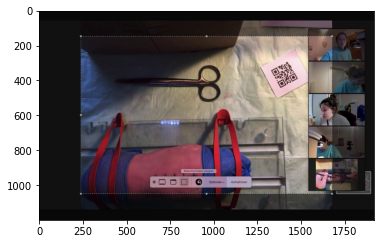

In [112]:

qr_data = dcv.get_parameters_for_crop_rotate_rescale()
plt.imshow(dcv.frame[:,:,::-1])
qr_data

In [ ]:

fn = dcv.do_crop_rotate_rescale(qr_data["bbox_scene_area"], qr_data["incision_bboxes"])
img = pigleg_cv.get_frame_to_process(fn)
plt.imshow(img[:,:,::-1])

In [62]:
Path(outputdir).absolute()

PosixPath('/webapps/piglegsurgery/piglegcv/del_test_video_output')

### Find splits

2023-12-14 13:59:37.441 | DEBUG    | run_report:bboxes_to_points:635 - Sort data N=6178
/webapps/piglegsurgery/piglegcv/run_report.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frame_ids_list = np.asarray(frame_ids).tolist()
2023-12-14 13:59:37.587 | DEBUG    | tools:save_json:15 - Writing 'del_test_video_output_copy/SA_20220707-190320/tracks_points.json'
2023-12-14 13:59:37.589 | DEBUG    | tools:save_json:26 - updated keys: ['frame_ids', 'data_pixels_0', 'data_pixels_1', 'data_pixels_2', 'data_pixels_3']
2023-12-14 13:59:37.624 | DEBUG    | pigleg_cv:find_stitch_ends_in_tracks:372 - find_stitch_end, n_clusters=3, outputdir=PosixPath('del_test_video_output_copy/SA_20220707-190320')
2023-12-14 13:59:37.632 | DEBUG    | pigleg_cv:find_stitch_ends_in_tracks:384 

[457, 1302, 1310, 1441, 1507, 1514, 1588, 1590]

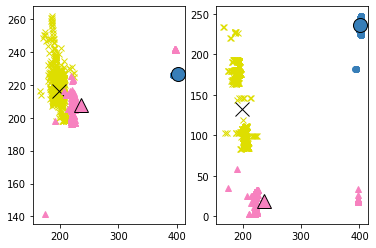

In [102]:
dcv._load_meta()
split_frames = dcv._find_stitch_ends_in_tracks(n_clusters=n_stitches, plot_clusters=True)
split_frames

## Do whole processing together


2023-12-14 12:13:06.639 | INFO     | pigleg_cv:run:88 - CV processing started on ../piglegsurgeryweb/media/upload/20231011-191116_2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht_2420162e9b953df5fcaf26ac64f0bd3a7ae78c36/2023_10_11_B_Seltmann_Charlotte_fortlaufende_Transcutannaht.mp4, outputdir=del_test_video_output
2023-12-14 12:13:06.641 | DEBUG    | pigleg_cv:run_video_processing:171 - Running video processing...
2023-12-14 12:13:06.662 | DEBUG    | run_perpendicular:get_frame_to_process:162 - 8965
2023-12-14 12:13:06.720 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:226 - device=cuda
2023-12-14 12:13:06.958 | DEBUG    | run_qr:get_bboxes:37 - [[     705.74       387.8      813.28      498.67     0.99424]
 [     286.06      376.03      391.35      479.65     0.99424]
 [     175.67      61.201      1344.3      1053.8     0.15124]
 [     230.59      12.319      1423.5      201.26     0.13009]
 [     251.47      528.07      1425.3      1055.9    0.092554]]
202

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2023-12-14 12:13:07,688 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - number of detected incisions = 1
2023-12-14 12:13:07.690 | DEBUG    | pigleg_cv:get_parameters_for_crop_rotate_rescale:237 - {'bbox_scene_area': [186.4540557861328,
                     203.48699951171875,
                     1314.715087890625,
                     1041.72412109375,
                     0.4179236888885498],
 'box': [[708, 399], [718, 495], [810, 486], [801, 390]],
 'incision_bboxes': [[549.2802124023438,
                      875.2634887695312,
                      787.151123046875,
                      942.4053955078125,
                      0.9340460896492004]],
 'incision_bboxes_old': [[546.6876220703125,
                          875.6588745117188,
                          788.8228759765625,
                          942.1117553710938,
                          0.9956039190292358]],
 'is_detected': True,
 'pix_size': 0.00031081825277836804,
 'pix_size_method': 'QR',

Fusing layers... 
IDetect.fuse
load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/incision_detection_models/220326_234659_mmdet.pth


2023-12-14 12:13:37,934 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - DEBUG - number of detected incisions = 1
2023-12-14 12:13:37.937 | DEBUG    | run_perpendicular:main_perpendicular:294 - len(imgs)=1
2023-12-14 12:13:37.974 | DEBUG    | tools:save_json:15 - Writing 'del_test_video_output/perpendicular_0.json'
2023-12-14 12:13:37.977 | DEBUG    | tools:save_json:24 - old keys: ['intersections', 'alphas']
2023-12-14 12:13:37.978 | DEBUG    | tools:save_json:26 - updated keys: ['intersections', 'alphas']
2023-12-14 12:13:38,226 - /webapps/piglegsurgery/piglegcv/stitch_detection_mmdet.py - DEBUG - cfg_path=PosixPath('stitch_detection_mmdet_config.py'), True
2023-12-14 12:13:38,227 - /webapps/piglegsurgery/piglegcv/stitch_detection_mmdet.py - DEBUG - checkpoint_path=PosixPath('/webapps/piglegsurgery/piglegcv/resources/stitch_detection_models/model.pth'), True
/home/appuser/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "Defa

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/stitch_detection_models/model.pth


2023-12-14 12:13:38.710 | DEBUG    | tools:save_json:26 - updated keys: ['stitch_labels', 'stitch_bboxes']
2023-12-14 12:13:38,712 - /webapps/piglegsurgery/piglegcv/stitch_detection_mmdet.py - DEBUG - number of detected stitches = 4
2023-12-14 12:13:38,712 - /webapps/piglegsurgery/piglegcv/stitch_detection_mmdet.py - DEBUG - Stitch detection finished, boxes in: del_test_video_output/stitch_detection_0.json
2023-12-14 12:13:38,767 - /webapps/piglegsurgery/piglegcv/stitch_detection_mmdet.py - DEBUG - R-squared upper line: 0.849
2023-12-14 12:13:38,768 - /webapps/piglegsurgery/piglegcv/stitch_detection_mmdet.py - DEBUG - R-squared lower line: 0.872
2023-12-14 12:13:38.915 | DEBUG    | pigleg_cv:run_image_processing:129 - Perpendicular finished.
2023-12-14 12:13:38.917 | DEBUG    | pigleg_cv:run_video_processing:187 - Single frame processing on cropped mediafile finished in 2.1607089042663574s.
2023-12-14 12:13:38.918 | DEBUG    | pigleg_cv:run_video_processing:189 - Image processing finis

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack/epoch.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1

2023-12-14 12:13:42,604 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-12-14 12:13:42,627 - /webapps/piglegsurgery/piglegcv/incision_detection_mmdet.py - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-12-14 12:13:42,628 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-12-14 12:13:42,628 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-12-14 12:13:42,862 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, t

load checkpoint from local path: /webapps/piglegsurgery/piglegcv/resources/tracker_model_bytetrack_hands_tools/epoch_2.pth


2023-12-14 12:13:43.756 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 0 by tracker


The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector_backbone_stage1_1_main_conv_bn_running_mean, ema_detector_backbone_stage1_1_main_conv_bn_running_var, ema_detector_backbone_stage1_1_main_conv_bn_num_batches_tracked, ema_detector_ba

2023-12-14 12:13:54.332 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 50 by tracker
2023-12-14 12:14:05.118 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 100 by tracker
2023-12-14 12:14:15.972 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 150 by tracker
2023-12-14 12:14:26.945 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 200 by tracker
2023-12-14 12:14:37.989 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 250 by tracker
2023-12-14 12:14:49.034 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 300 by tracker
2023-12-14 12:15:00.729 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 350 by tracker
2023-12-14 12:15:11.942 | DEBUG    | run_tracker_bytetrack:main_tracker_bytetrack:54 - Processing frame 400 by tracker
2023-12-14 12:15:23.110 | DEBUG    | run_tracker_

3545.533207047265


/webapps/piglegsurgery/piglegcv/run_report.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frame_ids_list = np.asarray(frame_ids).tolist()
2023-12-14 12:47:09.913 | DEBUG    | tools:save_json:15 - Writing 'del_test_video_output/tracks_points.json'
2023-12-14 12:47:09.915 | DEBUG    | tools:save_json:26 - updated keys: ['frame_ids', 'data_pixels_0', 'data_pixels_1', 'data_pixels_2', 'data_pixels_3']
2023-12-14 12:47:10.072 | DEBUG    | run_report:create_video_report_figure:542 - main_video_report: OK
2023-12-14 12:47:10.112 | DEBUG    | run_report:main_report:784 - Frame 0 processed!


b Needle holder
r Forceps
g Scissors


2023-12-14 12:47:15.074 | DEBUG    | run_report:main_report:784 - Frame 50 processed!
2023-12-14 12:47:19.988 | DEBUG    | run_report:main_report:784 - Frame 100 processed!
2023-12-14 12:47:24.935 | DEBUG    | run_report:main_report:784 - Frame 150 processed!
2023-12-14 12:47:29.886 | DEBUG    | run_report:main_report:784 - Frame 200 processed!
2023-12-14 12:47:34.793 | DEBUG    | run_report:main_report:784 - Frame 250 processed!
2023-12-14 12:47:39.714 | DEBUG    | run_report:main_report:784 - Frame 300 processed!
2023-12-14 12:47:44.595 | DEBUG    | run_report:main_report:784 - Frame 350 processed!
2023-12-14 12:47:49.453 | DEBUG    | run_report:main_report:784 - Frame 400 processed!
2023-12-14 12:47:54.429 | DEBUG    | run_report:main_report:784 - Frame 450 processed!
2023-12-14 12:47:59.308 | DEBUG    | run_report:main_report:784 - Frame 500 processed!
2023-12-14 12:48:04.236 | DEBUG    | run_report:main_report:784 - Frame 550 processed!
2023-12-14 12:48:09.140 | DEBUG    | run_rep

bbox
[251.5200653076172, 362.58263397216797, 364.0028991699219, 475.06546783447266, 0.9961403012275696]


/home/appuser/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2023-12-14 13:01:31.111 | DEBUG    | run_report:create_pdf_report:297 - main_report: figures del_test_video_output/graph_1c_trajectory.jpg is saved
2023-12-14 13:01:31.280 | DEBUG    | run_report:create_pdf_report:326 - main_report: figures del_test_video_output/fig_1a_forceps_graph.jpg is saved
2023-12-14 13:01:31.307 | DEBUG    | run_report:create_heatmap_report_plt:167 - points.shape=(3602, 2)
/home/appuser/.local/lib/python3.8/site-packages/seaborn/distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
2023-12-14 13:01:33.552 | DEBUG    | run_report:create_pdf_report:297 - main_report: figures del_test_video_output/graph_2c_trajectory.jpg is saved
2023-12-14 13:01:33.719 | DEBUG    | run_report:create_pdf_report:326 - main_report: figures del_test_

main_report: Video file del_test_video_output/__cropped.mp4 is processed!


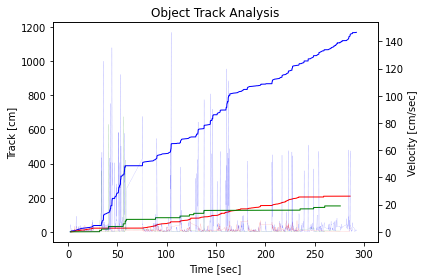

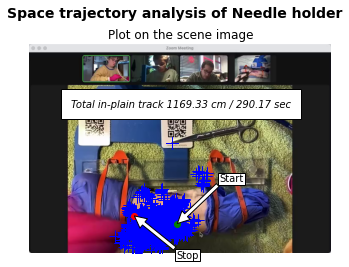

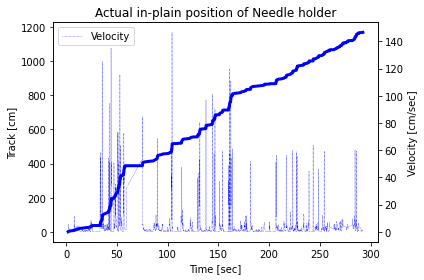

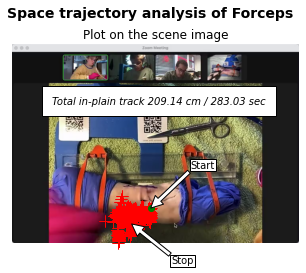

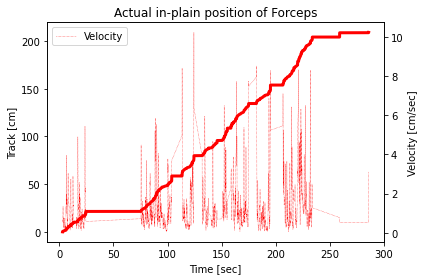

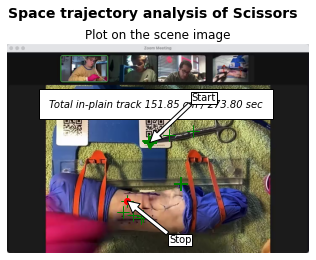

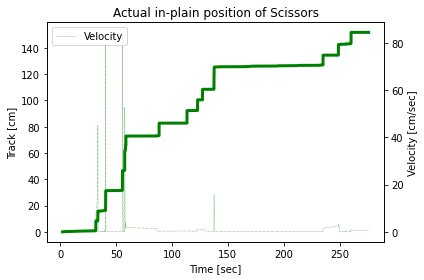

In [89]:
outputdir = "./del_test_video_output/"
# pigleg_cv.do_computer_vision(img_pths[0], outputdir , meta=None)
dcv = pigleg_cv.DoComputerVision(img_pths[0], outputdir, test_first_seconds=test_first_seconds, is_microsurgery=is_microsurgery)
# qr_data = dcv.get_parameters_for_crop_rotate_rescale()
# plt.imshow(dcv.frame)
# qr_data
dcv.run()

In [ ]:
# report_data = dcv.make_report()